<a href="https://colab.research.google.com/github/adarvens/nlpjcomp/blob/main/jcompv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import string
import array
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [4]:
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [5]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


for tamil

In [16]:
data = read_text("/content/drive/MyDrive/pairs/mkb.ta")
tamil = to_lines(data)
tamil = array(tamil)

In [18]:
tamil[0][0]

'மனதின் குரல், அக்டோபர் 2019'

for telugu

In [11]:
data = read_text("/content/drive/MyDrive/pairs/mkb.te")
telugu = to_lines(data)
telugu = array(telugu)

In [22]:
telugu[0][0]

'మన్ కి బాట్, అక్టోబర్ 2019'

In [23]:
ta_te=[]
# for i in tamil:
#   for j in telugu:
for i in range(len(tamil)):
  tmp=[]
  tmp.append(telugu[i][0])
  tmp.append(tamil[i][0])
  ta_te.append(tmp)

In [24]:
ta_te[:2]

[['మన్ కి బాట్, అక్టోబర్ 2019', 'மனதின் குரல், அக்டோபர் 2019'],
 ['సహచరులారా, ప్రపంచంలో ఫెస్టివల్ టూరిజానికి ఒక ప్రత్యేక ఆకర్షణ ఉంది.',
  'நண்பர்களே, உலகத்தில் பண்டிகைச் சுற்றுலா எனும் போதே ஒரு ஈர்ப்பு ஏற்பட்டு விடுகிறது.']]

text processing

In [26]:
ta_te = np.array(ta_te)
ta_te[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ta_te[:,0]]
ta_te[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ta_te[:,1]]

In [27]:
ta_te

array([['మన్ కి బాట్ అక్టోబర్ 2019', 'மனதின் குரல் அக்டோபர் 2019'],
       ['సహచరులారా ప్రపంచంలో ఫెస్టివల్ టూరిజానికి ఒక ప్రత్యేక ఆకర్షణ ఉంది',
        'நண்பர்களே உலகத்தில் பண்டிகைச் சுற்றுலா எனும் போதே ஒரு ஈர்ப்பு ஏற்பட்டு விடுகிறது'],
       ['మన భారత్ లో దేశీయ పండుగలలో ఫెస్టివల్ జానికి అపారమైన అవకాశాలున్నాయి',
        ' இதில் பண்டிகைச் சுற்றுலாவுக்கு ஏராளமான சாத்தியக்கூறுகள் இருக்கின்றன'],
       ...,
       ['దేశ అభివృధ్ధిలో మీ అభివృధ్ధే ఒక ముఖ్యమైన భాగం',
        'நாட்டின் முன்னேற்றத்திற்கு உங்களின் முன்னேற்றம் மிகவும் அவசியமாகும்'],
       ['మీకు ఎంత అభివృధ్ధి జరిగితే దేశం అంతగా ప్రగతిని సాధిస్తుంది',
        'நீங்கள் வளர்ச்சியடைந்தால் இந்த நாடும் வளர்ச்சியடையும்'],
       ['మీ అందరికీ నా అనేకానేక శుభాకాంక్షలు',
        'உங்கள் அனைவருக்கும் எனது நல்வாழ்த்துகள்']], dtype='<U412')

In [31]:
tel_l = []
tam_l = []

# populate the lists with sentence lengths
for i in ta_te[:,0]:
    tel_l.append(len(i.split()))

for i in ta_te[:,1]:
    tam_l.append(len(i.split()))

In [33]:
length_df = pd.DataFrame({'tel':tel_l, 'tam':tam_l})

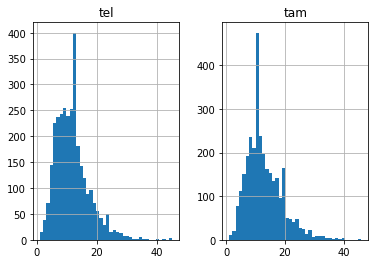

In [38]:
length_df.hist(bins = 40)
plt.show()

max of telugu is 42 and that of tamil 44

In [35]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [39]:
tel_tokenizer = tokenization(ta_te[:, 0])
tel_vocab_size = len(tel_tokenizer.word_index) + 1

tel_length = 42
print('Telugu Vocabulary Size: %d' % tel_vocab_size)

Telugu Vocabulary Size: 13300


In [43]:
tam_tokenizer = tokenization(ta_te[:, 1])
tam_vocab_size = len(tam_tokenizer.word_index) + 1

tam_length = 8
print('Tamil Vocabulary Size: %d' % tam_vocab_size)

Tamil Vocabulary Size: 13339


In [44]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

model

In [45]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ta_te, test_size=0.2, random_state = 12)

In [46]:
trainX = encode_sequences(tam_tokenizer, tam_length, train[:, 1])
trainY = encode_sequences(tel_tokenizer, tel_length, train[:, 0])

In [47]:
#validation set
testX = encode_sequences(tam_tokenizer, tam_length, test[:, 1])
testY = encode_sequences(tel_tokenizer, tel_length, test[:, 0])

In [48]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [49]:
model = build_model(tam_vocab_size, tel_vocab_size, tam_length, tel_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [50]:
filename = 'model.h1.7_nov_22'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
4/4 [==============================] - ETA: 0s - loss: 7.9608 
Epoch 1: val_loss improved from inf to 3.10489, saving model to model.h1.7_nov_22


4/4 [==============================] - 125s 32s/step - loss: 7.9608 - val_loss: 3.1049
Epoch 2/30
4/4 [==============================] - ETA: 0s - loss: 3.0349 
Epoch 2: val_loss improved from 3.10489 to 2.90138, saving model to model.h1.7_nov_22


4/4 [==============================] - 120s 31s/step - loss: 3.0349 - val_loss: 2.9014
Epoch 3/30
4/4 [==============================] - ETA: 0s - loss: 2.9184 
Epoch 3: val_loss did not improve from 2.90138
4/4 [==============================] - 102s 26s/step - loss: 2.9184 - val_loss: 2.9102
Epoch 4/30
4/4 [==============================] - ETA: 0s - loss: 3.1406 
Epoch 4: val_loss did not improve from 2.90138
4/4 [==============================] - 103s 26s/step - loss: 3.1406 - val_loss: 3.0413
Epoch 5/30
4/4 [==============================] - ETA: 0s - loss: 2.9003 
Epoch 5: val_loss did not improve from 2.90138
4/4 [==============================] - 102s 26s/step - loss: 2.9003 - val_loss: 2.9019
Epoch 6/30
4/4 [==============================] - ETA: 0s - loss: 2.8417 
Epoch 6: val_loss did not improve from 2.90138
4/4 [==============================] - 104s 26s/step - loss: 2.8417 - val_loss: 3.0207
Epoch 7/30
4/4 [==============================] - ETA: 0s - loss: 2.7753 
Epoch 7

4/4 [==============================] - 119s 32s/step - loss: 2.8789 - val_loss: 2.8896
Epoch 9/30
4/4 [==============================] - ETA: 0s - loss: 2.7265 
Epoch 9: val_loss did not improve from 2.88965
4/4 [==============================] - 102s 26s/step - loss: 2.7265 - val_loss: 3.0503
Epoch 10/30
4/4 [==============================] - ETA: 0s - loss: 2.7005 
Epoch 10: val_loss improved from 2.88965 to 2.82413, saving model to model.h1.7_nov_22


4/4 [==============================] - 118s 32s/step - loss: 2.7005 - val_loss: 2.8241
Epoch 11/30
4/4 [==============================] - ETA: 0s - loss: 2.6467 
Epoch 11: val_loss improved from 2.82413 to 2.82044, saving model to model.h1.7_nov_22


4/4 [==============================] - 116s 31s/step - loss: 2.6467 - val_loss: 2.8204
Epoch 12/30
4/4 [==============================] - ETA: 0s - loss: 2.7546 
Epoch 12: val_loss did not improve from 2.82044
4/4 [==============================] - 103s 26s/step - loss: 2.7546 - val_loss: 3.0035
Epoch 13/30
4/4 [==============================] - ETA: 0s - loss: 2.6969 
Epoch 13: val_loss did not improve from 2.82044
4/4 [==============================] - 101s 26s/step - loss: 2.6969 - val_loss: 2.9068
Epoch 14/30
4/4 [==============================] - ETA: 0s - loss: 2.6168 
Epoch 14: val_loss did not improve from 2.82044
4/4 [==============================] - 102s 27s/step - loss: 2.6168 - val_loss: 3.0161
Epoch 15/30
4/4 [==============================] - ETA: 0s - loss: 2.5679 
Epoch 15: val_loss did not improve from 2.82044
4/4 [==============================] - 102s 26s/step - loss: 2.5679 - val_loss: 3.0333
Epoch 16/30
4/4 [==============================] - ETA: 0s - loss: 2.6293

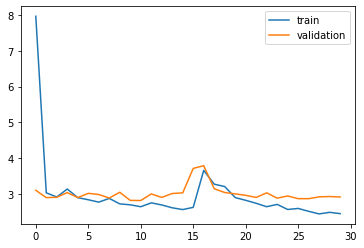

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [57]:
model = load_model('model.h1.7_nov_22')
# preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
predictions = np.argmax(model.predict(testX.reshape((testX.shape[0],testX.shape[1]))),axis=1)

20/20 [==============================] - 12s 512ms/step


In [58]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 512)            6829568   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 42, 512)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 42, 512)           2099200   
                                                                 
 dense (Dense)               (None, 42, 13300)         6822900   
                                                                 
Total params: 17,850,868
Trainable params: 17,850,868
Non-trainable params: 0
____________________________________________

In [64]:
model.save('/content/drive/MyDrive/saved_model/my_model1')

In [66]:
len(predictions)

620

In [69]:
preds_text = []
for i in predictions[:1]:
       print(i)
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], tel_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], tel_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

[41  3  5 ...  0  0  0]


In [70]:
pred_df = pd.DataFrame({'actual' : test[:1,0], 'predicted' : preds_text})

In [71]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head()